# Notes

Fourth iteration of the modeling:
- modulirized data processing
- model serialization

In [1]:
import os 
import re
import csv
import json
import math
import random

from itertools import chain
from datetime import datetime

import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# Constants

In [2]:
dir_root = os.path.join('..')
dir_data_root = os.path.join(dir_root, 'data')
dir_exercises = os.path.join(dir_data_root, 'json', 'patients')
dir_exercises_augmented = os.path.join(dir_data_root, 'json', 'patients_augmented')
dir_exercises_test = os.path.join(dir_data_root, 'json', 'test')

**TODO** Implement augmenation and patients sessions for the new data set

# Data prep

### Build training set

In [3]:
CONFIG = {
    'SEQ_MAX_LEN': 801,
    'NUM_EXERCISES': 9,
    'NUM_CLASSES': 6,
    'REGIONS':json.load(open(os.path.join('settings', 'pois_region_tpcnn.json'))),
    'AUGMENTED': True
}

In [4]:
CONFIG

{'SEQ_MAX_LEN': 801,
 'NUM_EXERCISES': 9,
 'NUM_CLASSES': 6,
 'REGIONS': {'LefteyeMidbottom': 'upper',
  'LefteyeMidtop': 'upper',
  'LefteyeInnercorner': 'upper',
  'LefteyeOutercorner': 'upper',
  'LefteyebrowInner': 'upper',
  'LefteyebrowCenter': 'upper',
  'RighteyeMidbottom': 'upper',
  'RighteyeMidtop': 'upper',
  'RighteyeInnercorner': 'upper',
  'RighteyeOutercorner': 'upper',
  'RighteyebrowInner': 'upper',
  'RighteyebrowCenter': 'upper',
  'NoseTip': 'lower',
  'MouthLowerlipMidbottom': 'lower',
  'MouthLeftcorner': 'lower',
  'MouthRightcorner': 'lower',
  'MouthUpperlipMidtop': 'lower',
  'ChinCenter': 'lower',
  'ForeheadCenter': 'upper',
  'LeftcheekCenter': 'lower',
  'RightcheekCenter': 'lower'},
 'AUGMENTED': True}

input for global region
801 is length of a series in excercise 
each series consist from 63 value, 21 POIs, each POI has 3 values: x,y,z

overall length of a series is 7209 (in paper 8019?)

In [5]:
i = 0 
sessions_id = set()
for file_name in os.listdir(dir_exercises):
    ids = file_name.split('_')
    session_id = f'{ids[0]}_{ids[1]}'
    sessions_id.add(session_id)
sessions_ids = sorted(list(sessions_id))

In [6]:
len(sessions_ids)

292

In [7]:
def pad_excercise_poi(data, poi):
    return tf.keras.preprocessing.sequence.pad_sequences(
        [
            data['pois'][poi]['xs'],
            data['pois'][poi]['ys'],
            data['pois'][poi]['zs']
        
        ],
        padding='pre',
        maxlen=CONFIG['SEQ_MAX_LEN'],
        dtype='float32')

In [37]:
def session_data(session_id, augmented = None):
    global_region = None
    upper_region = None
    lower_region = None
    exercises_data = []
    
    for exercise_id in range(CONFIG['NUM_EXERCISES']):
        #todo add handling when augmented is defined and number
        if augmented:
            exercises_data.append(json.load(open(os.path.join(dir_exercises_augmented, f'{session_id}_0{exercise_id + 1}_{augmented}.json'))))
        else:
            exercises_data.append(json.load(open(os.path.join(dir_exercises, f'{session_id}_0{exercise_id + 1}.json'))))
    
    for poi in sorted(CONFIG['REGIONS'].keys()):
        poi_series = None
        
        for exercise_id in range(CONFIG['NUM_EXERCISES']):
            exercise_series = pad_excercise_poi(exercises_data[exercise_id], poi)
            if poi_series is not None:
                poi_series = np.hstack((poi_series, exercise_series))
            else:
                poi_series = exercise_series
        
        if global_region is not None:
            global_region = np.concatenate((global_region, poi_series), axis=0)
        else:
            global_region = poi_series
        
        if CONFIG['REGIONS'][poi] == 'upper':
            if upper_region is not None:
                upper_region = np.concatenate((upper_region, poi_series), axis=0)
            else:
                upper_region = poi_series
        if CONFIG['REGIONS'][poi] == 'lower':
            if lower_region is not None:
                lower_region = np.concatenate((lower_region, poi_series), axis=0)
            else:
                lower_region = poi_series

    
    y = int(exercises_data[0]['meta']['evaluation']) - 1
    

    return [
        global_region,
        upper_region,
        lower_region,
        y
    ]

In [38]:
xslist_global = list()
xslist_upper = list()
xslist_lower = list()
yslist = list()
incomlete_sessions = []
i = 0
for session_id in sessions_ids:
    try:
        _xs_global, _xs_upper, _xs_lower, _ys = session_data(session_id)
        

        yslist.append(_ys)
        xslist_global.append(_xs_global)  
        xslist_upper.append(_xs_upper)
        xslist_lower.append(_xs_lower)
    except:
        print(f'issues with session_id: {session_id}')
        incomlete_sessions.append(session_id)
        continue
    
    if CONFIG['AUGMENTED']:
        for augmentation_id in range(4):
            try:
                _xs_global, _xs_upper, _xs_lower, _ys = session_data(session_id, augmentation_id)


                yslist.append(_ys)
                xslist_global.append(_xs_global)  
                xslist_upper.append(_xs_upper)
                xslist_lower.append(_xs_lower)
            except:  
                break
    
ys = np.array(yslist, dtype='int')
xs_global = np.array(xslist_global, dtype='float32') 
xs_upper = np.array(xslist_upper, dtype='float32') 
xs_lower = np.array(xslist_lower, dtype='float32') 


print(ys.shape)
print(xs_global.shape)
print(xs_upper.shape)
print(xs_lower.shape)
print(f'Incomplete sessions {len(incomlete_sessions)}')

issues with session_id: 105_126
issues with session_id: 107_50
issues with session_id: 107_51
issues with session_id: 110_120
issues with session_id: 116_249
issues with session_id: 145_298
issues with session_id: 156_310
issues with session_id: 17_83
issues with session_id: 17_84
issues with session_id: 187_344
issues with session_id: 19_100
issues with session_id: 1_76
issues with session_id: 20_140
issues with session_id: 23_7
issues with session_id: 257_416
issues with session_id: 26_134
issues with session_id: 27_92
issues with session_id: 28_78
issues with session_id: 28_79
issues with session_id: 32_99
issues with session_id: 35_127
issues with session_id: 3_69
issues with session_id: 44_38
issues with session_id: 44_40
issues with session_id: 47_124
issues with session_id: 4_141
issues with session_id: 55_109
issues with session_id: 55_112
issues with session_id: 57_137
issues with session_id: 58_16
issues with session_id: 60_125
issues with session_id: 63_58
issues with sessio

In [39]:
print(ys)

[0 0 0 ... 0 0 0]


In [40]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


## Modeling

In [41]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import AveragePooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.utils import class_weight

In [42]:
def get_dnn(inputLayer): 
    m = Dense(4, activation="relu")(inputLayer)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [43]:
def get_regional_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(3, (32), padding='same', activation='relu')(inputLayer)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (32), padding='same', activation='relu')(m)
    m = Conv1D(3, (64), padding='same', activation='relu')(m)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (64), padding='same', activation='relu')(m)
    m = Dense(128, activation="relu")(m)
    m = Dropout(0.5)(m)
    m = Flatten()(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [44]:
def get_global_cnn(inputLayer):
    chanDim = -1
    
    m = Conv1D(21, (6), padding='same', activation='relu')(inputLayer)
    m = AveragePooling1D((2))(m)
    m = Conv1D(9, (6), padding='same', activation='relu')(m)
    m = Conv1D(9, (16), padding='same', activation='relu')(m)
    m = AveragePooling1D((2))(m)
    m = Conv1D(3, (16), padding='same', activation='relu')(m)
    m = Dense(128, activation="relu")(m)
    m = Dropout(0.5)(m)
    m = Flatten()(m)
    m = Model(inputs=inputLayer, outputs=m)

    return m

In [45]:
def get_model():
    input_global = Input(shape=xs_global.shape[1:])
    model_global = get_global_cnn(input_global)
    
    input_upper = Input(shape=xs_upper.shape[1:])
    model_upper = get_regional_cnn(input_upper)  

    input_lower = Input(shape=xs_lower.shape[1:])
    model_lower = get_regional_cnn(input_lower)  
    
    
    model_contatenate = concatenate([
        model_global.output,
        model_upper.output,
        model_lower.output,
    ])
    
    model_contatenate = Dense(6, activation="softmax")(model_contatenate)
        
    model = Model(inputs=[
        model_global.input,
        model_upper.input,
        model_lower.input
    ], outputs=model_contatenate)

    model.compile(
        loss="sparse_categorical_crossentropy", 
        optimizer=Adam(learning_rate=1e-3, decay=1e-3 / 200),
        metrics=['accuracy']
    )
    
    
    return model

In [46]:
test_model = get_model()
test_model.summary()

Model: "model_43"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 63, 7209)]   0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 39, 7209)]   0           []                               
                                                                                                  
 input_33 (InputLayer)          [(None, 24, 7209)]   0           []                               
                                                                                                  
 conv1d_120 (Conv1D)            (None, 63, 21)       908355      ['input_31[0][0]']               
                                                                                           

In [47]:
print(set(ys))

{0, 1, 2, 3, 4, 5}


### K-fold evaluation

In [48]:
k = 5
k_limit = 5
train = 0.8
val = 0.2
test = 0.2

In [57]:
VERBOSE = 0
EPOCHS = 50
BATCH_SIZE = 32

In [58]:
from sklearn.model_selection import KFold

In [59]:
def get_k_indx(k, n):

    k_fold = KFold(n_splits=k)
    train_ = []
    val_ = []
    test_ = []
    indx = []

    for train_indices, test_indices in k_fold.split(ys):
        n_k = len(train_indices)
        val_split = int(n_k * train)
        indx.append([train_indices[:val_split],train_indices[val_split + 1:], test_indices])
    
    return indx

In [60]:
%matplotlib inline

{0: 0.3864522417153996, 1: 1.1906906906906907, 2: 0.9790123456790123, 3: 3.776190476190476, 4: 2.6433333333333335, 5: 1.101388888888889}


2024-02-23 16:17:50.192923: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:18:02.540806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:24:13.387184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.62      0.47      0.53       103
           1       0.20      0.29      0.24        35
           2       0.36      0.80      0.50        25
           3       0.00      0.00      0.00        20
           4       0.14      0.17      0.15        30
           5       0.00      0.00      0.00        35

    accuracy                           0.33       248
   macro avg       0.22      0.29      0.24       248
weighted avg       0.34      0.33      0.32       248

{0: 0.39809236947791166, 1: 1.0489417989417988, 2: 0.9790123456790123, 3: 3.776190476190476, 4: 1.888095238095238, 5: 1.3912280701754387}


2024-02-23 16:24:25.172566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:24:37.741868: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:30:34.632021: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471

              precision    recall  f1-score   support

           0       0.54      0.51      0.52       113
           1       0.11      0.25      0.15        20
           2       0.08      0.20      0.12        25
           3       0.00      0.00      0.00        20
           4       0.00      0.00      0.00        10
           5       0.29      0.17      0.21        60

    accuracy                           0.31       248
   macro avg       0.17      0.19      0.17       248
weighted avg       0.33      0.31      0.31       248

{0: 0.3611111111111111, 1: 1.2957516339869282, 2: 1.3216666666666668, 3: 2.6433333333333335, 4: 2.403030303030303, 5: 1.101388888888889}


2024-02-23 16:30:46.544038: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:30:59.300949: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:37:01.115642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.34      0.56      0.42        79
           1       0.32      0.32      0.32        44
           2       0.17      0.08      0.11        60
           3       0.00      0.00      0.00         5
           4       0.33      0.20      0.25        25
           5       0.20      0.14      0.17        35

    accuracy                           0.29       248
   macro avg       0.23      0.22      0.21       248
weighted avg       0.27      0.29      0.27       248

{0: 0.42634408602150536, 1: 1.3216666666666668, 2: 1.1200564971751412, 3: 2.403030303030303, 4: 1.7622222222222221, 5: 0.9790123456790123}


2024-02-23 16:37:15.111152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:37:28.693869: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:43:30.833768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: Undefi

              precision    recall  f1-score   support

           0       0.48      0.41      0.44       135
           1       0.38      0.46      0.41        46
           2       0.26      0.17      0.20        42
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         5
           5       0.00      0.00      0.00        20

    accuracy                           0.33       248
   macro avg       0.19      0.17      0.18       248
weighted avg       0.37      0.33      0.35       248

{0: 0.4066666666666667, 1: 1.2015151515151514, 2: 1.1200564971751412, 3: 2.937037037037037, 4: 2.033333333333333, 5: 1.0166666666666666}


2024-02-23 16:43:45.398799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:43:57.759636: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-23 16:50:04.877473: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


              precision    recall  f1-score   support

           0       0.48      0.44      0.46       125
           1       0.20      0.20      0.20        25
           2       0.14      0.12      0.13        43
           3       0.00      0.00      0.00        30
           4       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        15

    accuracy                           0.26       248
   macro avg       0.14      0.13      0.13       248
weighted avg       0.29      0.26      0.27       248



/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/alanchen/.local/share/virtualenvs/research-face-excercises-dynamics-o_HFBNSW/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

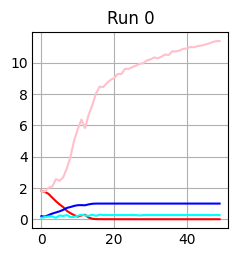

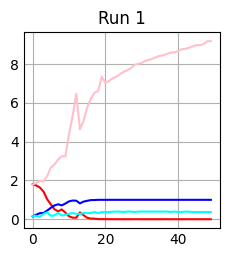

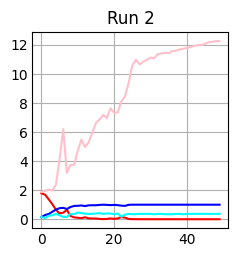

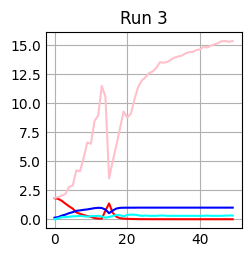

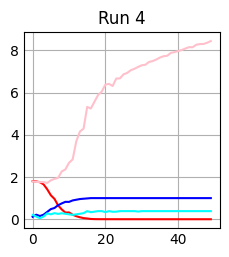

In [61]:
indxs = get_k_indx(k, len(ys))
models = []

for i in range(k_limit):
    train_indx, val_indx, test_indx  = indxs[i]
    
    xs_global_i = xs_global[train_indx]
    xs_global_i_val = xs_global[val_indx]
    xs_global_i_test = xs_global[test_indx]
    
    xs_upper_i = xs_upper[train_indx]
    xs_upper_i_val = xs_upper[val_indx]
    xs_upper_i_test = xs_upper[test_indx]
    
    xs_lower_i = xs_lower[train_indx]
    xs_lower_i_val = xs_lower[val_indx]
    xs_lower_i_test = xs_lower[test_indx]
    
    ys_i = ys[train_indx]
    ys_i_val = ys[val_indx]
    ys_i_test = ys[test_indx]
    
    
    class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes = np.unique(ys_i),
                                                 y=ys_i)
    available_classes = np.unique(ys_i)
    weight_training_classes = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
    }
    
    for indx, value in enumerate(class_weights):
        weight_training_classes[available_classes[indx]] = value

    print(weight_training_classes)

    model = get_model()

    model_callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20)
    ]
    
    hist = model.fit(
        x=[
            xs_global_i, 
            xs_upper_i,
            xs_lower_i], y=ys_i, 
        validation_data=([
            xs_global_i_val,
            xs_upper_i_val,
            xs_lower_i_val], ys_i_val),
        batch_size=BATCH_SIZE, 
        epochs=EPOCHS,
        class_weight=weight_training_classes,
        #callbacks=model_callbacks,
        verbose=VERBOSE)
    
    models.append(model)
    
    # visualizing losses and accuracy
    train_loss = hist.history['loss']
    val_loss   = hist.history['val_loss']
    train_acc  = hist.history['accuracy']
    val_acc    = hist.history['val_accuracy']
    xc         = range(len(hist.history['loss']))    
    
    plt.figure()
    plt.title(f'Run {i}')
    plt.plot(xc, train_loss, color='red')
    plt.plot(xc, val_loss, color='pink')
    plt.plot(xc, train_acc, color='blue')
    plt.plot(xc, val_acc, color='cyan')
    
    y_pred = model.predict([
        xs_global_i_test,
        xs_upper_i_test,
        xs_lower_i_test],verbose=0)
    y_pred_bool = np.argmax(y_pred, axis=1)

    print(classification_report(ys_i_test, y_pred_bool))

# Model Serialization 

In [62]:
serialize = False
best_model = 2

In [55]:
dir_models = os.path.join(dir_root, 'models')
dir_model = os.path.join(dir_models, 'type4-with-fe_no-aug_005')

In [56]:
if serialize:
    model = models[best_model]
    model.save(dir_model)